In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error


# 2. Đọc file csv và gắng index với giá Close

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Analyst/Datasets/AMD Historical Data.csv')
df1=df.reset_index()['Price']
len(df)

1624

# 3.Scaler data

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test

In [5]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
print(train_size, test_size, val_size)

1136 324 164


# 5.Hàm Create Dataset

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# import numpy
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-time_step-1):
# 		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
# 		dataX.append(a)
# 		dataY.append(dataset[i + time_step, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

#6.Reshape into X=t,t+1,t+2..t+99 and Y=t+100

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [10]:
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM

In [11]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

# 8. Define GRU Model

In [12]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train

In [13]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 6s 138ms/step - loss: 0.0285 - val_loss: 0.0154
Epoch 2/100
17/17 [==============================] - 1s 68ms/step - loss: 0.0055 - val_loss: 0.0113
Epoch 3/100
17/17 [==============================] - 1s 88ms/step - loss: 6.4539e-04 - val_loss: 0.0038
Epoch 4/100
17/17 [==============================] - 1s 70ms/step - loss: 3.1547e-04 - val_loss: 0.0018
Epoch 5/100
17/17 [==============================] - 1s 84ms/step - loss: 2.2618e-04 - val_loss: 0.0015
Epoch 6/100
17/17 [==============================] - 2s 94ms/step - loss: 2.0431e-04 - val_loss: 0.0015
Epoch 7/100
17/17 [==============================] - 2s 115ms/step - loss: 1.9916e-04 - val_loss: 0.0015
Epoch 8/100
17/17 [==============================] - 2s 94ms/step - loss: 1.9809e-04 - val_loss: 0.0015
Epoch 9/100
17/17 [==============================] - 1s 79ms/step - loss: 1.9424e-04 - val_loss: 0.0013
Epoch 10/100
17/17 [==============================] - 1s 39ms/step - l

# 10.Dự báo dữ liệu test, val

In [14]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val


In [15]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE

In [16]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 84.75164808610798
Validation MAE: 83.0411271986548
Testing RMSE: 106.7586372892307
Testing MAE: 104.50360008006488


# 13. Dự báo 30 ngày tiếp theo

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=time_step
x_input=val_data[-n_steps:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

i=0
while(i<30):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [18]:
# x_input=val_data[60:].reshape(1,-1)
# x_input.shape

# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

# from numpy import array

# lst_output=[]
# n_steps = 103
# i=0
# while(i<30):

#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1


In [19]:
x_input.shape

(1, 100, 1)

# 14.Vẽ hình

Validation RMSE: 84.75164808610798
Validation MAE: 83.0411271986548
Testing RMSE: 106.7586372892307
Testing MAE: 104.50360008006488


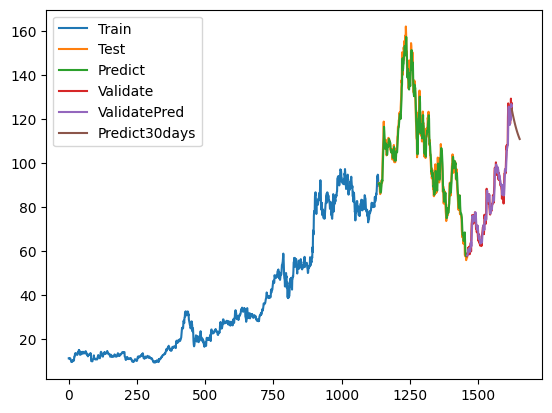

In [20]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()
# print(lst_output)

In [21]:
# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
# plt.plot(scaler.inverse_transform(train_data))
# test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,scaler.inverse_transform(test_data))
# test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,(y_pred))
# val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,scaler.inverse_transform(val_data))
# val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
# plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
# plt.show()

# 15.Vẽ hình Predict 30 days


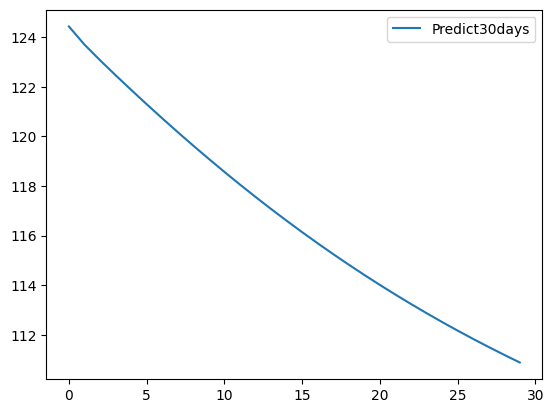

In [22]:
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()

In [23]:
scaler.inverse_transform(lst_output)[:30, 0]


array([124.43237765, 123.70266695, 123.07334574, 122.46846569,
       121.87832663, 121.2989504 , 120.73039149, 120.17287697,
       119.62679739, 119.09237981, 118.5698967 , 118.0594934 ,
       117.56125164, 117.07521683, 116.60144347, 116.13985891,
       115.69043588, 115.25308357, 114.82765666, 114.41404615,
       114.01205224, 113.62158408, 113.24234196, 112.87415332,
       112.51679108, 112.17006451, 111.83369206, 111.50744666,
       111.19108307, 110.88435608])